## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot_tools
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals import joblib
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from library.utils import file_utils
from scipy.misc import toimage
%matplotlib inline

None


In [2]:
from sklearn.neural_network import MLPClassifier

In [3]:
total_time = 0
exp_no = 103
file_no = 7
output_directory = '../logs/cifar10/' + str(file_no).zfill(2) + '_mlp_raw_cross_val/' + 'exp_no_' + str(exp_no).zfill(3) + '/'

In [4]:
data_source = 'Website'
search_method = 'grid'
train_validate_split_data=None
one_hot=False

In [5]:
total_time = 0
mlp_max_iter = 1000
exp_jobs = 10
num_images_required = 0.2
num_folds = 10

In [6]:
param_grid = [
  {'hidden_layer_sizes': [(3072,3072), (4000, 4000)], 
   'solver': ['lbfgs', 'adam'],
   'alpha': [1e-5, 1e-6, 1e-7]
  },
 ]
param_name = 'exp_' + str(exp_no).zfill(3)

## Step 0: Load and visualize the CIFAR 10 dataset

In [7]:
start = time.time()
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required,
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 0] Dataset loaded in %5.6f ms' %((end-start)*1000))
print('Dataset size: ' + str(cifar10.train.data.shape))
num_train_images = cifar10.train.data.shape[0]
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 10000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 2.1444 seconds
[ Step 0] Dataset loaded in 2145.123720 ms
Dataset size: (10000, 3072)


Plotting CIFAR 10 Train Dataset


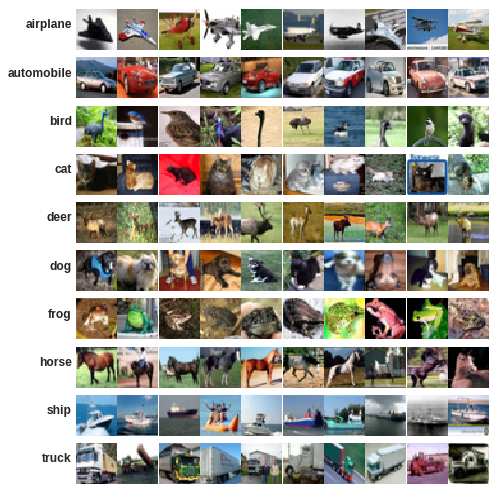

Plotting CIFAR 10 Test Dataset


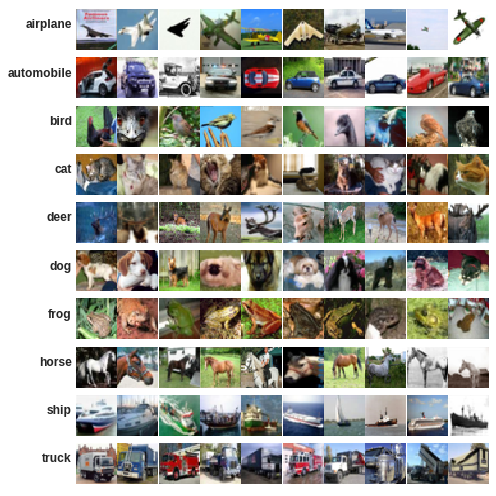

In [8]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

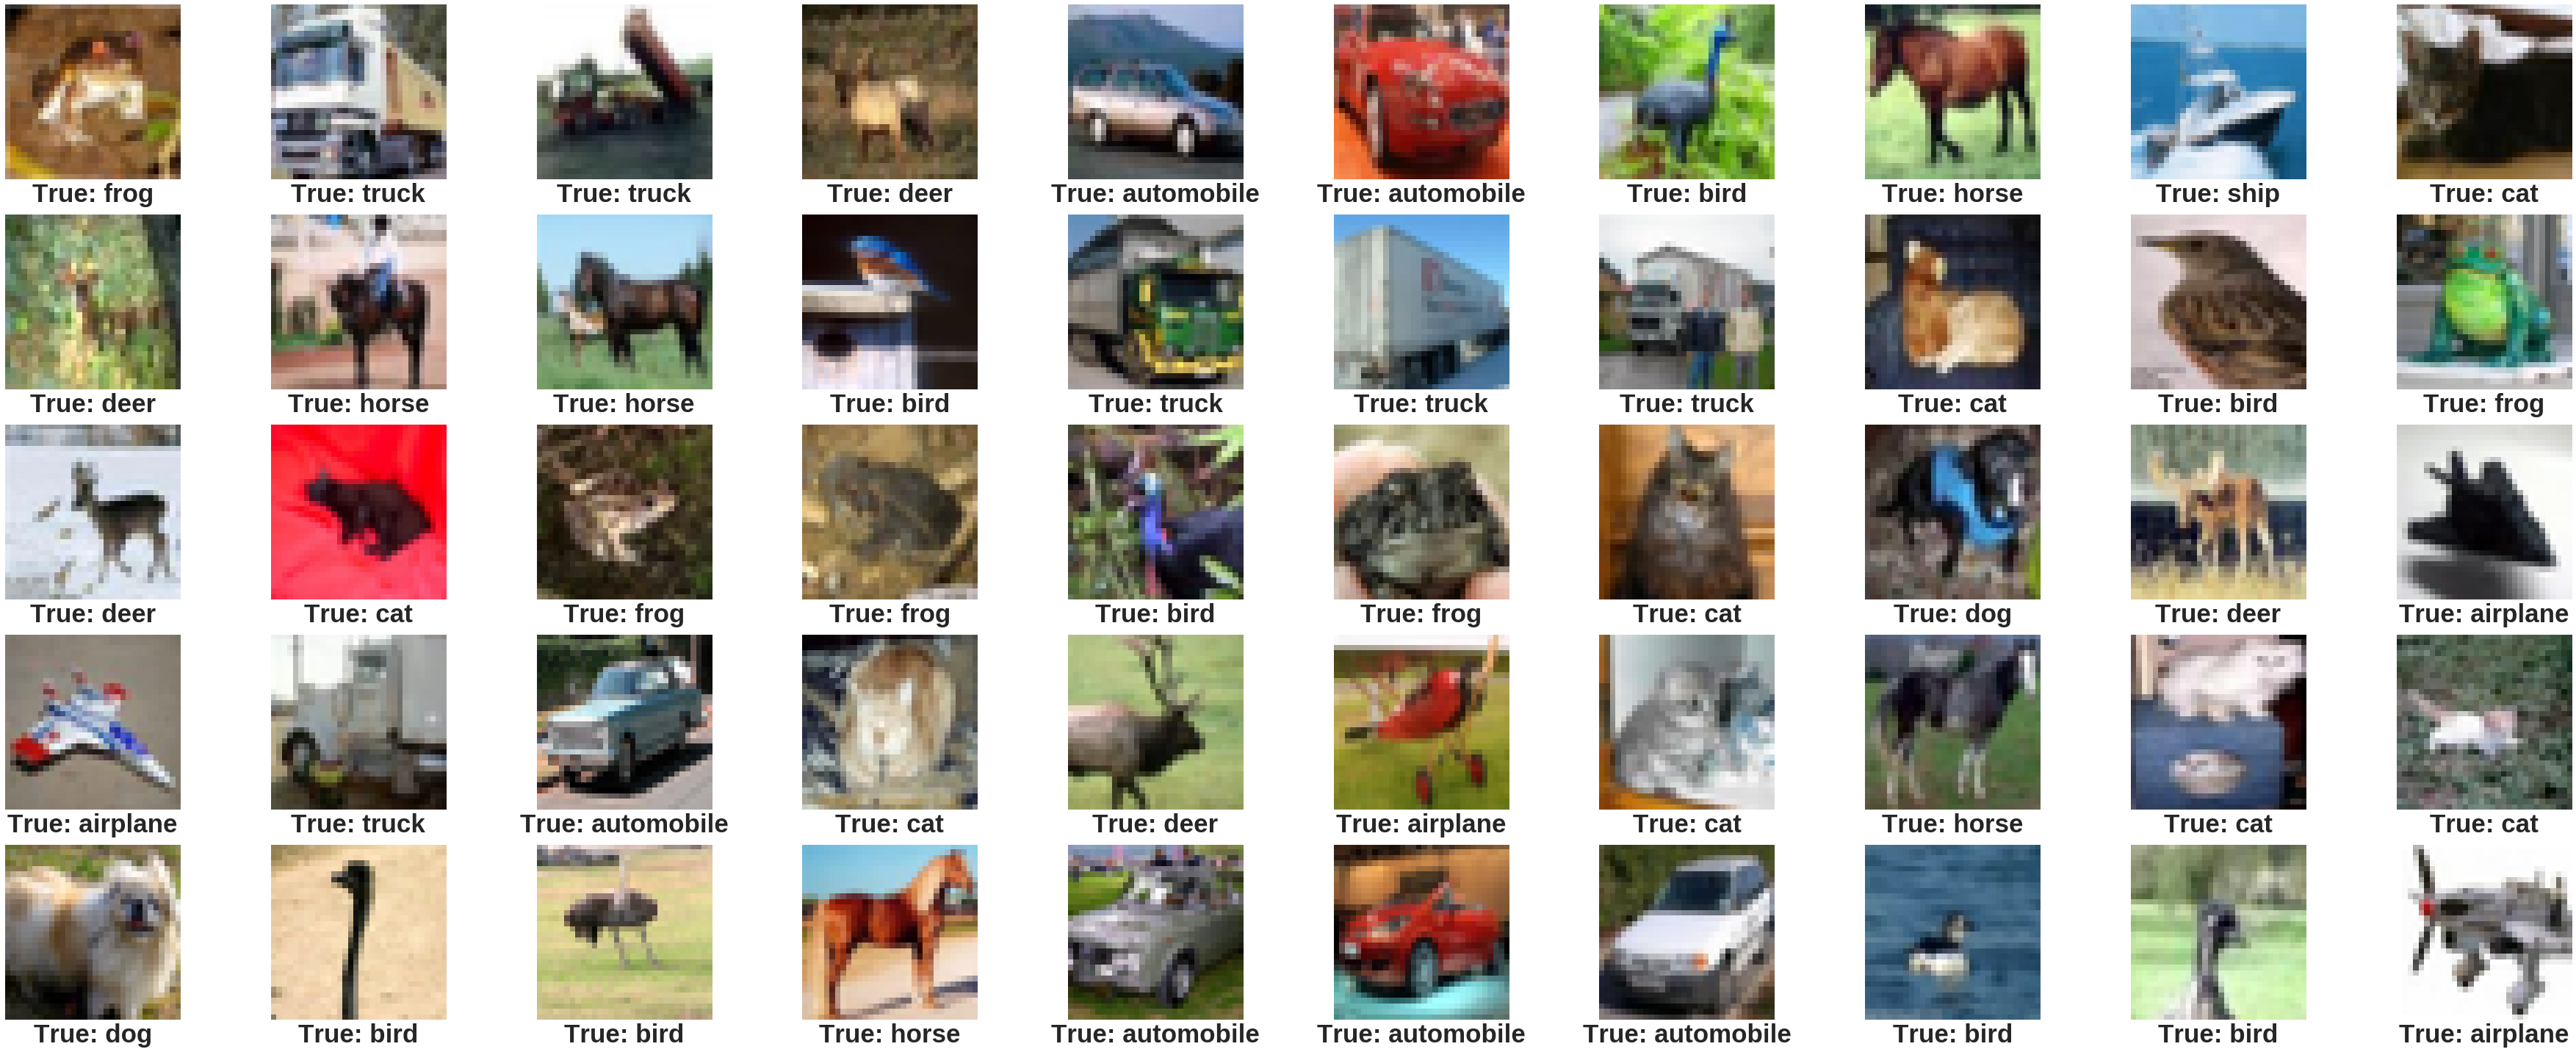

True

In [9]:
cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

In [10]:
print('Training images')
print(cifar10.train.data[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])
print('[ Step 0.1] Working with only %d images' %num_train_images)

Training images
[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 [ 28  37  38 ...,  28  37  46]
 [170 168 177 ...,  82  78  80]]
Training classes
[6 9 9 4 1]
Testing images
[[158 159 165 ..., 124 129 110]
 [235 231 232 ..., 178 191 199]
 [158 158 139 ...,   8   3   7]
 [155 167 176 ...,  50  52  50]
 [ 65  70  48 ..., 136 146 117]]
Testing classes
[3 8 8 0 6]
[ Step 0.1] Working with only 10000 images


## Step 1: Preprocess data

In [11]:
start = time.time()
ss = StandardScaler()
data_images = ss.fit_transform(cifar10.train.data)
test_images = ss.fit_transform(cifar10.test.data)
end = time.time()
print('[ Step 1] Dataset transformations done in %5.6f ms' %((end-start)*1000))
print('Training the classifier on %d images' % num_train_images)
print('Dataset size: ' + str(cifar10.train.data.shape))
total_time += (end-start)

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


[ Step 1] Dataset transformations done in 816.001415 ms
Training the classifier on 10000 images
Dataset size: (10000, 3072)


## Step 3: Parameters for estimatinng best model in MLP

In [12]:
print('Parameters to serach for')
print('\n'.join([str(param) for param in param_grid])); print()

Parameters to serach for
{'hidden_layer_sizes': [(3072, 3072), (4000, 4000)], 'solver': ['lbfgs', 'adam'], 'alpha': [1e-05, 1e-06, 1e-07]}



In [13]:
scores = []
scores_mean = []
scores_std = []

## Step 3.1: Run a search method for best parameters

In [ ]:
mlp_clf = MLPClassifier(random_state=0, max_iter=mlp_max_iter, verbose=True)
print(mlp_clf)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)


In [ ]:
start = time.time()
if search_method == 'grid':
    print('Applying GridSearchCV')
    estimator = GridSearchCV(mlp_clf, param_grid, cv=num_folds, scoring='accuracy', verbose=3, n_jobs=exp_jobs)
elif search_method == 'random':
    print('Applying RandomizedSearchCV')
    estimator = RandomizedSearchCV(mlp_clf, param_grid, cv=num_folds, scoring='accuracy', n_iter=10, 
                              random_state=0, verbose=3, n_jobs=exp_jobs)
else:
    print('Applying GridSearchCV')
    estimator = GridSearchCV(mlp_clf, param_grid, cv=num_folds, scoring='accuracy', verbose=3, n_jobs=exp_jobs)
print(estimator)
estimator_result = estimator.fit(data_images, cifar10.train.class_labels)
end = time.time()
total_time += (end-start)
print('Total Time taken for cross validation and finding best parameters: %.4f ms' %((end-start)*1000))

Applying GridSearchCV
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=10,
       param_grid=[{'hidden_layer_sizes': [(3072, 3072), (4000, 4000)], 'solver': ['lbfgs', 'adam'], 'alpha': [1e-05, 1e-06, 1e-07]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] alpha=1e-05, hidden_layer_sizes=(3072, 3072), solver=lbfgs ......
[CV] alpha=1e-05, hidden_layer_sizes=(3072, 3072), solver=lbfgs .....

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 262.2min


[CV] alpha=1e-05, hidden_layer_sizes=(4000, 4000), solver=adam .......
Iteration 1, loss = 3.96248917
Iteration 2, loss = 1.73396836
Iteration 1, loss = 3.35051723
Iteration 3, loss = 1.56408818
Iteration 2, loss = 1.67170178
Iteration 4, loss = 1.43725087
Iteration 3, loss = 1.52481886
Iteration 5, loss = 1.31459791
Iteration 4, loss = 1.38661015
Iteration 6, loss = 1.18905685
Iteration 5, loss = 1.27324117
Iteration 7, loss = 1.07464205
Iteration 6, loss = 1.15235553
Iteration 8, loss = 0.95465074
Iteration 7, loss = 1.02818684
[CV]  alpha=1e-05, hidden_layer_sizes=(3072, 3072), solver=lbfgs, score=0.434870, total=267.0min
[CV] alpha=1e-05, hidden_layer_sizes=(4000, 4000), solver=adam .......
Iteration 9, loss = 0.84931436
Iteration 8, loss = 0.91442027
Iteration 1, loss = 3.73348036
Iteration 10, loss = 0.77689212
Iteration 9, loss = 0.80876549
Iteration 2, loss = 1.67448134
Iteration 11, loss = 0.68153293
Iteration 10, loss = 0.67926821
Iteration 3, loss = 1.50395501
Iteration 12, 

In [ ]:
print('\n'.join('{}: {}'.format(k, v) for k, v in estimator.cv_results_.items())); print()
print('Scores for each set of parameters')
print('\n'.join([str(param) for param in estimator.grid_scores_])); print()
print('Best score')
print(estimator.best_score_); print()
print('Parameters corresponding to best score')
print(estimator.best_params_); print()

## Step 3.1.1 Plot error lines showing +/- std. errors of the scores

In [ ]:
means = estimator_result.cv_results_['mean_test_score']
stds = estimator_result.cv_results_['std_test_score']
params = estimator_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

## Step 4: Save the generated model to file

In [ ]:
start = time.time()
file_utils.mkdir_p(output_directory)
model_output_path = output_directory + '07_' + param_name + '.pkl'
joblib.dump(estimator, model_output_path)
end = time.time()
print('[ Step 4] Write obtained model to %s in %.6f ms' %(model_output_path, ((end-start)*1000)))
total_time += (end-start)

In [ ]:
scores = []
exp = []
dict_key = ['train', 'test']
for key in dict_key:
    scores_list = []
    for i in range(num_folds):
        key_name = 'split' + str(i) + '_' + key + '_score'
        scores_list.append(estimator.cv_results_[key_name].tolist())
    scores.append(scores_list)
scores = np.array(scores)
means = np.mean(np.array(scores).T, axis=1)
stds = np.std(np.array(scores).T, axis=1)

In [ ]:
plot_tools.plot_variance(scores, means, stds, legend=['Training data', 'Validation data'], 
                         plot_title=['Training scores for best parameters for MLP using raw pixels in CIFAR 10',
                                     'Validation scores for best parameters for MLP using raw pixels in CIFAR 10'], 
                         fig_size=(800,600), plot_xlabel=['MLP Parameters','MLP Parameters'], 
                         plot_ylabel=['Training accuracy of the model','Validation accuracy of the model'], plot_lib='bokeh', 
                         matplotlib_style='default', bokeh_notebook=True)

## Step 5: Run the predictor on test data and generate predictions

In [ ]:
start = time.time()
prediction_numbers = estimator.predict(test_images)
prediction_classes = []
num_test_images = test_images.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])
end = time.time()
print('[ Step 9] Make prediction on test dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

In [ ]:
cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 5.1 Print accuracy score of the classifier

In [ ]:
start = time.time()
plot_tools.plot_confusion_matrix(cifar10.test.class_labels, prediction_numbers, classes=cifar10.classes,
                              normalize=True, title='Confusion matrix for test set')
print(skm.classification_report(cifar10.test.class_labels, prediction_numbers, target_names=cifar10.classes))
test_accuracy = skm.accuracy_score(cifar10.test.class_labels, prediction_numbers, normalize=True)
print('Accuracy score on test data: ' + str(test_accuracy))
end = time.time()
total_time += (end-start)

In [ ]:
start = time.time()
print('Prediction done on %d images' %cifar10.test.data.shape[0])
print('Accuracy of the classifier: %.4f' %estimator.score(test_images, cifar10.test.class_labels))
end = time.time()
total_time += (end-start)

## Step 6: Write predictions to csv file

In [ ]:
start = time.time()
indices = np.arange(1, test_images.shape[0]+1)
predictions = np.column_stack((indices, prediction_classes))
file_utils.mkdir_p(output_directory)
output_csv_file = output_directory + '07_' + param_name + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 6] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

## Step 7: Save the notebook to HTML file

In [ ]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [ ]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

In [ ]:
current_file = './' + theNotebook + '.ipynb'
output_file = output_directory + str(file_no).zfill(2) + '_exp_no_' + str(exp_no) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(output_directory) 
output_HTML(current_file, output_file)

In [ ]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))